In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 1000
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.model_selection import permutation_test_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pickle
import os

## Target: Remitter

In [2]:
df = pd.read_csv("../../data/final_dataset_remitter.csv")
df.head()

,participants_ID,DISC/REP,indication,formal_status,Dataset,Consent,sessSeason,sessTime,Responder,Remitter,...,ever_used_cigarette,hours_since_last_cigarette,ever_used_coffee,hours_since_last_coffee,ever_used_beer,hours_since_last_beer,ever_used_drugs,hours_since_last_drugs,hours_since_last_meal,hours_since_last_sleep
0,sub-87999321,DISCOVERY,MDD,MDD,MDD-rTMS,YES,spring,NaN,1,1,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,5.0,7.0
1,sub-88000181,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,0,0,...,0.0,NaN,1.0,9.0,1.0,15.0,1.0,0.0,3.0,7.0
2,sub-88000313,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,1,1,...,1.0,9.0,1.0,9.0,0.0,NaN,1.0,0.0,3.0,9.0
3,sub-88000489,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,1,1,...,0.0,NaN,1.0,5.0,1.0,13.0,1.0,0.0,5.0,9.0
4,sub-88000533,DISCOVERY,MDD,MDD,MDD-rTMS,YES,summer,NaN,1,1,...,1.0,8.0,1.0,9.0,1.0,13.0,1.0,0.0,3.0,5.0


In [3]:
# pull out rows where Dataset = MDD-rTMS
print("All data shape:", df.shape)
df = df[df['Dataset'] == 'MDD-rTMS']
print("Only MDD data shape:", df.shape)

All data shape: (226, 114)
Only MDD data shape: (132, 114)


In [4]:
missing_counts = df.isnull().sum()
missing_counts_sorted = missing_counts.sort_values() # sort
print(missing_counts_sorted)

print("Row missing hearing:", df[df["hearing"].isna()].index)
print("Row missing well:", df[df["well"].isna()].index)

participants_ID                 0
BDI_pre                         0
BDI_post                        0
n_oddb_FN                       0
n_oddb_CN                       0
n_oddb_FP                       0
EO                              0
EC                              0
nrSessions                      0
gender                          0
sessID                          0
Remitter                        0
Responder                       0
n_oddb_CP                       0
sessSeason                      0
Consent                         0
Dataset                         0
formal_status                   0
indication                      0
DISC/REP                        0
age                             0
n_wm_CN                         1
n_wm_CP                         1
n_wm_FP                         1
n_wm_FN                         1
ever_used_coffee                1
well                            1
vision                          1
hearing                         1
rTMS_protocol 

In [5]:
duplicate_ids = df["participants_ID"].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids > 1].index

# print(df[df["participants_ID"].isin(duplicate_ids)])
# noticed that some participants have multiple sessions of data, so we decided
# to only keep the first entry for each participant

df = df.drop_duplicates(subset="participants_ID", keep="first")
print("Shape after keeping only first entry for each participant:", df.shape)

Shape after keeping only first entry for each participant: (124, 114)


### Preprocessing & splitting

In [6]:
X = df[['age', 'gender', 'education', 'BDI_pre', 'ever_used_drugs']]
y = df['Remitter']

# binary vars float --> str
X = X.copy()
X['gender'] = X['gender'].map({1.0: 'male', 0.0: 'female'})

print("X shape:", X.shape)
print("X columns:", X.columns)
print("X column datatypes:", X.dtypes)
print(X.head())

X shape: (124, 5)
X columns: Index(['age', 'gender', 'education', 'BDI_pre', 'ever_used_drugs'], dtype='object')
X column datatypes: age                float64
gender              object
education          float64
BDI_pre            float64
ever_used_drugs    float64
dtype: object
     age  gender  education  BDI_pre  ever_used_drugs
0  49.66    male       18.0     20.0              1.0
1  45.99  female       11.0     47.0              1.0
2  35.38  female       17.0     21.0              1.0
3  42.36    male       18.0     21.0              1.0
4  45.14  female       17.0     42.0              1.0


In [7]:
# construct preprocesser
# decide which encoder to use on each feature
onehot_ftrs = ['gender', 'ever_used_drugs']
std_ftrs = ['age', 'education', 'BDI_pre']

# one hot pipeline
X['ever_used_drugs'] = X['ever_used_drugs'].fillna(99)
onehot_transformer = Pipeline(steps=[
    ('imputer0', SimpleImputer(strategy='constant')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# numeric pipeline with imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='median')),  # fills missing values with median
    ('scaler', StandardScaler())                     # scales features
])

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_ftrs), 
        ('std', numeric_transformer, std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

In [8]:
# outer split: stratified split test and other
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 

print(X_train_val.shape)
print(X_test.shape)

# inner split: stratified k fold with k = 4 (60-20-20)
inner_split = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(inner_split.split(X_train_val, y_train_val)):
    print(f"Fold {fold+1}")
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)

(99, 5)
(25, 5)
Fold 1
X_train shape: (74, 5)
X_val shape: (25, 5)
Fold 2
X_train shape: (74, 5)
X_val shape: (25, 5)
Fold 3
X_train shape: (74, 5)
X_val shape: (25, 5)
Fold 4
X_train shape: (75, 5)
X_val shape: (24, 5)


In [9]:
# try preprocessor on the last fold
print("Before preprocessing...")
print("X train:", X_train.shape)
print("X val:", X_val.shape)
print("X test:", X_test.shape, "\n")

X_train_prep = clf.fit_transform(X_train)

# relabel the columns after transformation
onehot_feature_names = clf.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out()
new_feature_names = list(onehot_feature_names) + std_ftrs
print(new_feature_names)

X_train_prep = pd.DataFrame(X_train_prep, columns=new_feature_names)
X_val_prep = pd.DataFrame(clf.transform(X_val), columns=new_feature_names)
X_test_prep = pd.DataFrame(clf.transform(X_test), columns=new_feature_names)

# print number of data points after preprocessing
print("After preprocessing...")
print("X train:", X_train_prep.shape)
print("X val:", X_val_prep.shape)
print("X test:", X_test_prep.shape)

Before preprocessing...
X train: (75, 5)
X val: (24, 5)
X test: (25, 5) 

['gender_female', 'gender_male', 'ever_used_drugs_0.0', 'ever_used_drugs_1.0', 'age', 'education', 'BDI_pre']
After preprocessing...
X train: (75, 7)
X val: (24, 7)
X test: (25, 7)


In [10]:
# try simple model on data
log_reg = LogisticRegression(solver='saga', max_iter=100000000)
log_reg.fit(X_train_prep, y_train)
y_pred_val = log_reg.predict(X_val_prep)
y_pred_train = log_reg.predict(X_train_prep)
print("Accuracy on validation set:", accuracy_score(y_val,y_pred_val))
print("Accuracy on training set:", accuracy_score(y_train,y_pred_train))

Accuracy on validation set: 0.5
Accuracy on training set: 0.6133333333333333


### Pipeline

In [20]:
def MLpipe_SKFold(X, y, preprocessor, ML_algo, param_grid, model_name, eval_metric, num_states=1, do_permutation_test=True):
    '''
    Pipeline with:
        Splitting method -- StratifiedKFold
        Evaluation metric -- Depends on input
    '''

    test_scores = []
    best_models = []
    cv_scores = []
    perm_scores_list = []
    perm_pvalues = []

    for i in range(num_states):
        # Define random state
        random_state = 29*(i+1)
        print(f"---Running random state {random_state}---")

        # ---SPLIT---
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state) 
        kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

        # ---PREPROCESS---
        # Main preprocessor is fed into function as "preprocessor"
        final_scaler = StandardScaler()

        # ---CONSTRUCT PIPELINE & GRID SEARCH---
        pipeline = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring=eval_metric, return_train_score=True, n_jobs=-1, verbose=True)
        grid.fit(X_other, y_other)

        results = pd.DataFrame(grid.cv_results_)
        # print("\nGrid search results:\n", results)

        # ---SAVE BEST MODEL PER RANDOM STATE PER MODEL---
        best_model = grid.best_estimator_
        best_models.append(best_model)
        print('Best model parameters:', grid.best_params_)
        y_test_pred = best_model.predict(X_test)

        if eval_metric == "accuracy":
            best_test_score = accuracy_score(y_test, y_test_pred)
        elif eval_metric == "precision":
            best_test_score = precision_score(y_test, y_test_pred, average="macro")
        elif eval_metric == "f1_macro":
            best_test_score = f1_score(y_test, y_test_pred, average="macro")
        elif eval_metric == "f1_weighted":
            best_test_score = f1_score(y_test, y_test_pred, average="weighted")
        else:
            raise ValueError("Evaluation metric not handled in this pipeline.")
            
        test_scores.append(best_test_score)
        print(f"Test score for random state {29*i}: {best_test_score:.4f}")

        # ---OPTIONAL PERMUTATION TEST---
        if do_permutation_test:
            cv_score, perm_scores, p_value = permutation_test_score(
                best_model,
                X_other,
                y_other,
                scoring=eval_metric,
                cv=kf,
                n_permutations=1000,
                random_state=random_state,
                n_jobs=-1
            )
            cv_scores.append(cv_score)
            perm_scores_list.append(perm_scores)
            perm_pvalues.append(p_value)
            print(f"No permutation CV score: {cv_score:.4f}")
            print(f"Permutation test p-value: {p_value:.4f}")
        
    # ---SAVE ALL BEST MODELS AND TEST SCORES PER MODEL IN RESULTS---
    file_path = os.path.join('../../results/mdd/', f'{model_name}_{eval_metric}_remitter.save')
    with open(file_path, 'wb') as file:
        pickle.dump((best_models, test_scores), file)

    return (
        test_scores,
        best_models,
        cv_scores if do_permutation_test else None,
        perm_scores_list if do_permutation_test else None,
        perm_pvalues if do_permutation_test else None,
    )

In [21]:
# define model algorithms and parameter grids
models = {
    'SimpleLogisticRegression': (
        LogisticRegression(solver='saga', max_iter=1000000), {} 
    ),
    'L1LogisticRegression': (
        LogisticRegression(penalty='l1', solver='saga', max_iter=1000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ),
    'L2LogisticRegression': (
        LogisticRegression(penalty='l2', solver='saga', max_iter=1000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ),
    'ElasticNet': (
        LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100000000),
        {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'logisticregression__l1_ratio': [0.0001, 0.001, 0.01, 0.1, 1]}
    ),
    'RandomForestClassifier': (
        RandomForestClassifier(random_state=42),
        {'randomforestclassifier__n_estimators': [100],
         'randomforestclassifier__max_depth': [1, 3, 5, 10, 20, 100, 200],
         'randomforestclassifier__max_features': [0.25, 0.5, 0.75, 1.0, None]}
    ),
    'SupportVectorClassifier': (
        SVC(probability=True),
        {'svc__C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e5],
         'svc__gamma': [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]}
    ),
}

In [22]:
# evaluation metric = accuracy
summary_acc = {}
perm_plot_data = {}
for model_name, (algo, param_grid) in models.items():
    print(f"\nTraining {model_name}...")
    test_scores, best_models, cv_scores, perm_scores_list, perm_pvalues  = MLpipe_SKFold(X, y, preprocessor, algo, param_grid, model_name, 'accuracy')
    print("Test Accuracy Scores:", test_scores)
    print("Permutation Test p-values:", perm_pvalues)
    summary_acc[model_name] = (np.mean(test_scores), np.mean(cv_scores), np.mean(perm_scores_list), np.std(perm_scores_list), np.mean(perm_pvalues))
    perm_plot_data[model_name] = (cv_scores, perm_scores_list, perm_pvalues)

# display the summary
print("\nSummary of Results:")
for model_name, (mean_test_score, mean_cv_score, mean_perm_scores, std_perm_scores, mean_pvalue) in summary_acc.items():
    print(f"{model_name}: Mean test score = {mean_test_score:.4f}, Mean CV score = {mean_cv_score:.4f}, Permutation scores = {mean_perm_scores:.4f} +/- {std_perm_scores:.4f}, Mean p-value = {mean_pvalue:.4f}")


Training SimpleLogisticRegression...
---Running random state 29---
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best model parameters: {}
Test score for random state 0: 0.7600
No permutation CV score: 0.5967
Permutation test p-value: 0.0519
Test Accuracy Scores: [0.76]
Permutation Test p-values: [0.05194805194805195]

Training L1LogisticRegression...
---Running random state 29---
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Best model parameters: {'logisticregression__C': 100}
Test score for random state 0: 0.7600
No permutation CV score: 0.6071
Permutation test p-value: 0.0260
Test Accuracy Scores: [0.76]
Permutation Test p-values: [0.025974025974025976]

Training L2LogisticRegression...
---Running random state 29---
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Best model parameters: {'logisticregression__C': 10}
Test score for random state 0: 0.7600
No permutation CV score: 0.6171
Permutation test p-value: 0.0160
Test Accuracy Scores: [0.7

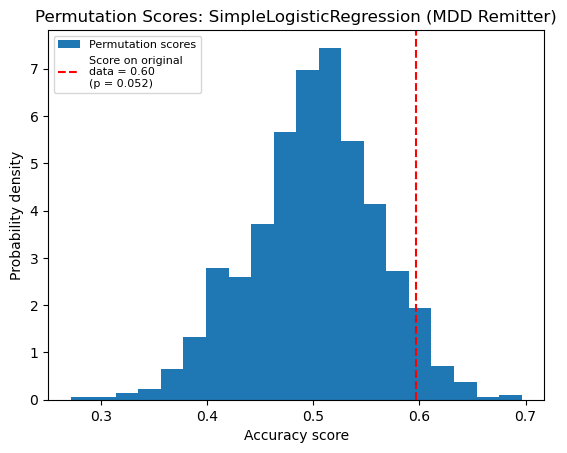

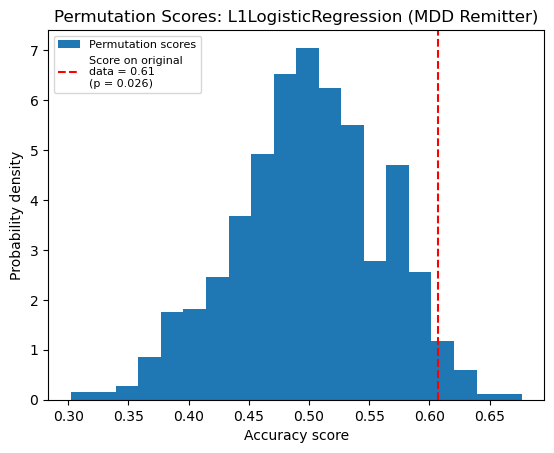

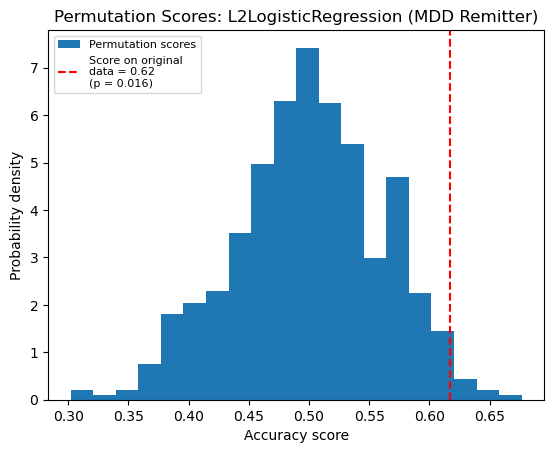

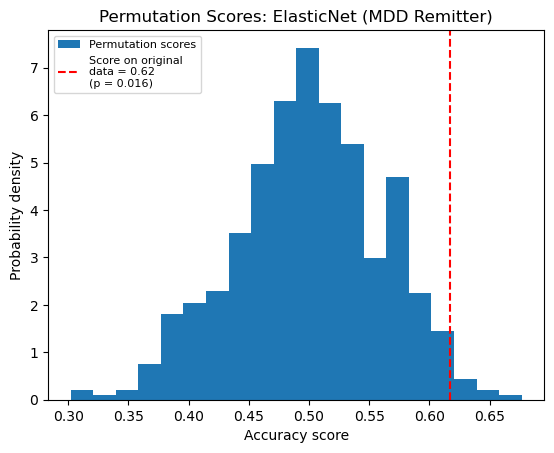

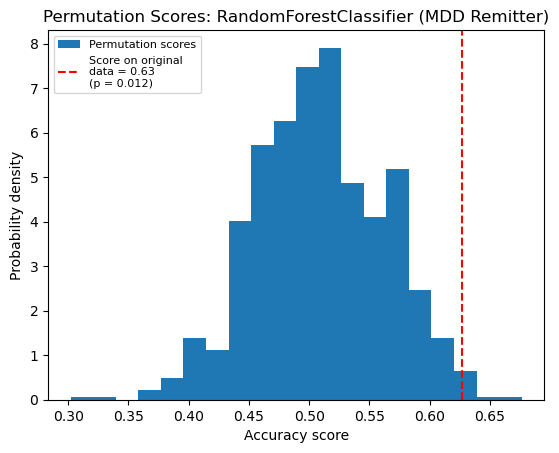

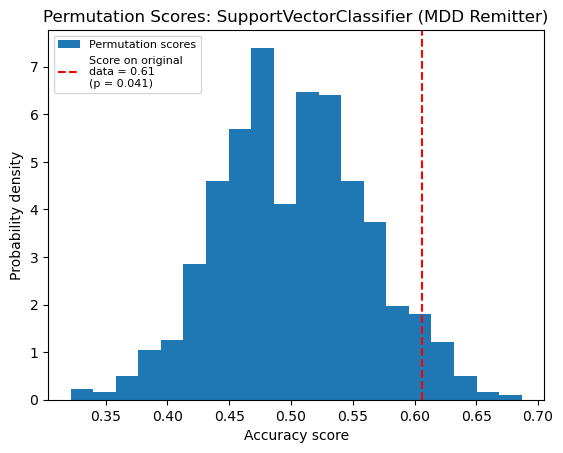

In [ ]:
# generate permutation plots
for model_name, (cv_scores, perm_scores_list, p_values) in perm_plot_data.items():
    cv_score = cv_scores[0]
    perm_scores = perm_scores_list[0]
    p_value = p_values[0]

    fig, ax = plt.subplots()
    ax.hist(perm_scores, bins=20, density=True, label="Permutation scores")
    ax.axvline(
        cv_score,
        ls="--",
        color="r",
        label=f"Score on original\ndata = {cv_score:.2f}\n(p = {p_value:.3f})"
    )
    ax.legend(fontsize=8)
    ax.set_xlabel("Accuracy score")
    _ = ax.set_ylabel("Probability density")
    ax.set_title(f"Permutation Scores: {model_name} (MDD Remitter)")

### Interpretability

In [ ]:
file = open('../../results/mdd/SimpleLogisticRegression_accuracy_remitter.save', 'rb')
best_models, test_scores = pickle.load(file)
file.close()

# get best model
top_one_index = np.argsort(test_scores)[-1:][0]  
best_model = best_models[top_one_index]
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer0',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender',
                                                   'ever_used_drugs']),
                                                 ('std',
                                                  Pipeline(steps=[('imputer2',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education',
                                                   'BDI_pre'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000000, solver='saga'))])

LogisticRegression(max_iter=1000000, solver='saga')


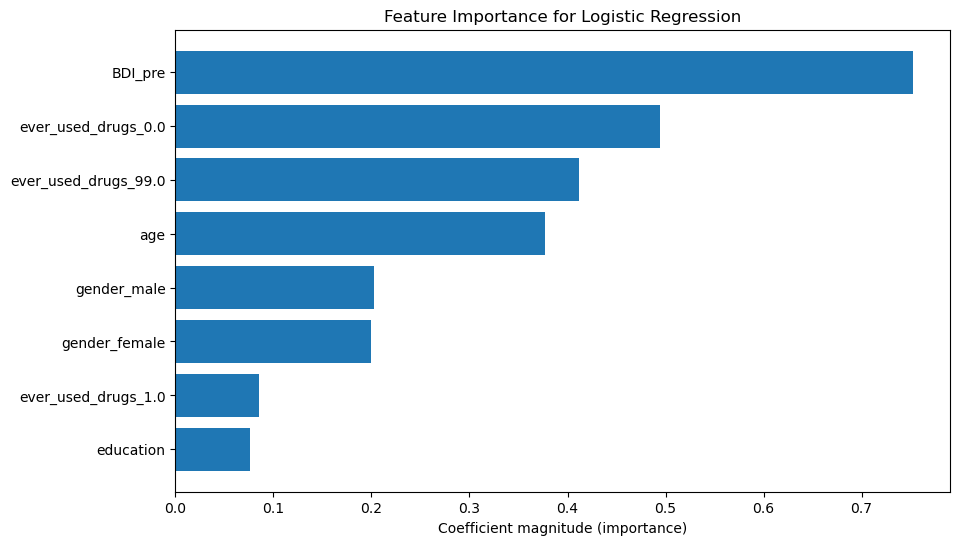

In [ ]:
log_reg_model = best_model.named_steps['logisticregression']
print(log_reg_model)

# get the preprocessed feature names
preprocessor = best_model.named_steps['columntransformer']
onehot_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out()
numeric_columns = std_ftrs
feature_names = np.concatenate([onehot_columns, numeric_columns])

# get coefficients
coefs = log_reg_model.coef_[0]  # binary classification

# Put in dataframe
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefs),
    'coef': coefs
}).sort_values(by='importance', ascending=False)

# plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Coefficient magnitude (importance)')
plt.title('Feature Importance for Logistic Regression')
plt.show()